In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


/Users/pragathi.vetrivelmurugan/Desktop/TSAI/TSAI-Assignment-6/tsai_env/lib/python3.13/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


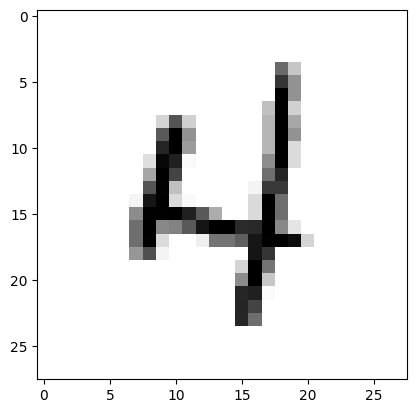

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


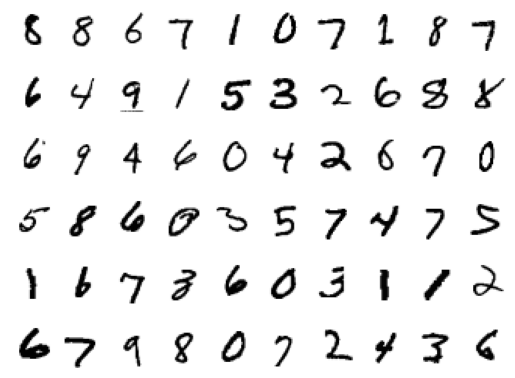

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#### Model Definition

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=0),
            nn.ReLU()
        )# 26X26X32
        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU()
        )# 24X24X64

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(64, 64, 1),
            nn.ReLU()
        )#10X10X64

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=0),
            nn.ReLU()
        )# 8X8X32
        self.convblock5 = nn.Sequential(
            nn.Conv2d(32, 16, 3),
            nn.ReLU()
        )# 6X6X16
        # # OUTPUT BLOCK
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(64, 32, 3, padding=0),
        #     nn.ReLU()
        # ) # 10X10X32

        self.fc1 = nn.Linear(8*8*16, 100)
        self.fc2 = nn.Linear(100, 10)
        #self.fc2 = nn.Linear(10*10*1, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = x.view(-1, 8*8*16)  # Flatten the tensor
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

#### Model Summary

In [23]:
!pip install torchsummary tqdm
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
cpucpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6           [-1, 64, 12, 12]           4,160
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]          18,464
              ReLU-9           [-1, 32, 10, 10]               0
           Conv2d-10             [-1, 16, 8, 8]           4,624
  

#### Model Training and Testing

In [24]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [25]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.09878119081258774 Batch_id=937 Accuracy=89.03: 100%|█| 938/938 [01:13<00:
Loss=0.09878119081258774 Batch_id=937 Accuracy=89.03: 100%|█| 938/938 [01:13<00:



Test set: Average loss: 0.0693, Accuracy: 9773/10000 (97.73%)

EPOCH: 1


Loss=0.10424485802650452 Batch_id=937 Accuracy=97.96: 100%|█| 938/938 [01:09<00:




Test set: Average loss: 0.0479, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.14228025078773499 Batch_id=937 Accuracy=98.52: 100%|█| 938/938 [01:09<00:




Test set: Average loss: 0.0423, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.18669776618480682 Batch_id=937 Accuracy=98.80: 100%|█| 938/938 [01:09<00:




Test set: Average loss: 0.0486, Accuracy: 9852/10000 (98.52%)

EPOCH: 4


Loss=0.01811409741640091 Batch_id=937 Accuracy=98.99: 100%|█| 938/938 [01:08<00:




Test set: Average loss: 0.0404, Accuracy: 9872/10000 (98.72%)

EPOCH: 5


Loss=0.005947089288383722 Batch_id=937 Accuracy=99.15: 100%|█| 938/938 [01:08<00




Test set: Average loss: 0.0305, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.0012308137957006693 Batch_id=937 Accuracy=99.31: 100%|█| 938/938 [01:08<0




Test set: Average loss: 0.0342, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.0006862345617264509 Batch_id=937 Accuracy=99.36: 100%|█| 938/938 [01:08<0




Test set: Average loss: 0.0401, Accuracy: 9883/10000 (98.83%)

EPOCH: 8


Loss=0.1653829962015152 Batch_id=937 Accuracy=99.48: 100%|█| 938/938 [01:09<00:0
Loss=0.1653829962015152 Batch_id=937 Accuracy=99.48: 100%|█| 938/938 [01:09<00:0



Test set: Average loss: 0.0337, Accuracy: 9899/10000 (98.99%)

EPOCH: 9


Loss=8.421565144089982e-05 Batch_id=937 Accuracy=99.50: 100%|█| 938/938 [01:08<0
Loss=8.421565144089982e-05 Batch_id=937 Accuracy=99.50: 100%|█| 938/938 [01:08<0



Test set: Average loss: 0.0362, Accuracy: 9889/10000 (98.89%)

EPOCH: 10


Loss=0.006785619538277388 Batch_id=937 Accuracy=99.54: 100%|█| 938/938 [01:08<00




Test set: Average loss: 0.0427, Accuracy: 9885/10000 (98.85%)

EPOCH: 11


Loss=0.0005918226670473814 Batch_id=937 Accuracy=99.60: 100%|█| 938/938 [01:08<0




Test set: Average loss: 0.0298, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.0007158457301557064 Batch_id=937 Accuracy=99.64: 100%|█| 938/938 [01:08<0




Test set: Average loss: 0.0343, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.017371568828821182 Batch_id=937 Accuracy=99.65: 100%|█| 938/938 [01:08<00




Test set: Average loss: 0.0408, Accuracy: 9898/10000 (98.98%)

EPOCH: 14


Loss=0.002570617012679577 Batch_id=937 Accuracy=99.71: 100%|█| 938/938 [01:08<00




Test set: Average loss: 0.0415, Accuracy: 9903/10000 (99.03%)



Selected random misclassified image with true label: 5
Image shape: torch.Size([1, 1, 28, 28])
convblock1 output shape: torch.Size([1, 32, 26, 26])
convblock2 output shape: torch.Size([1, 64, 24, 24])
pool1 output shape: torch.Size([1, 64, 12, 12])
convblock3 output shape: torch.Size([1, 64, 12, 12])
convblock4 output shape: torch.Size([1, 32, 10, 10])
convblock5 output shape: torch.Size([1, 16, 8, 8])
fc1 output shape: torch.Size([1, 100])
fc2 output shape: torch.Size([1, 10])
Predicted label: 3


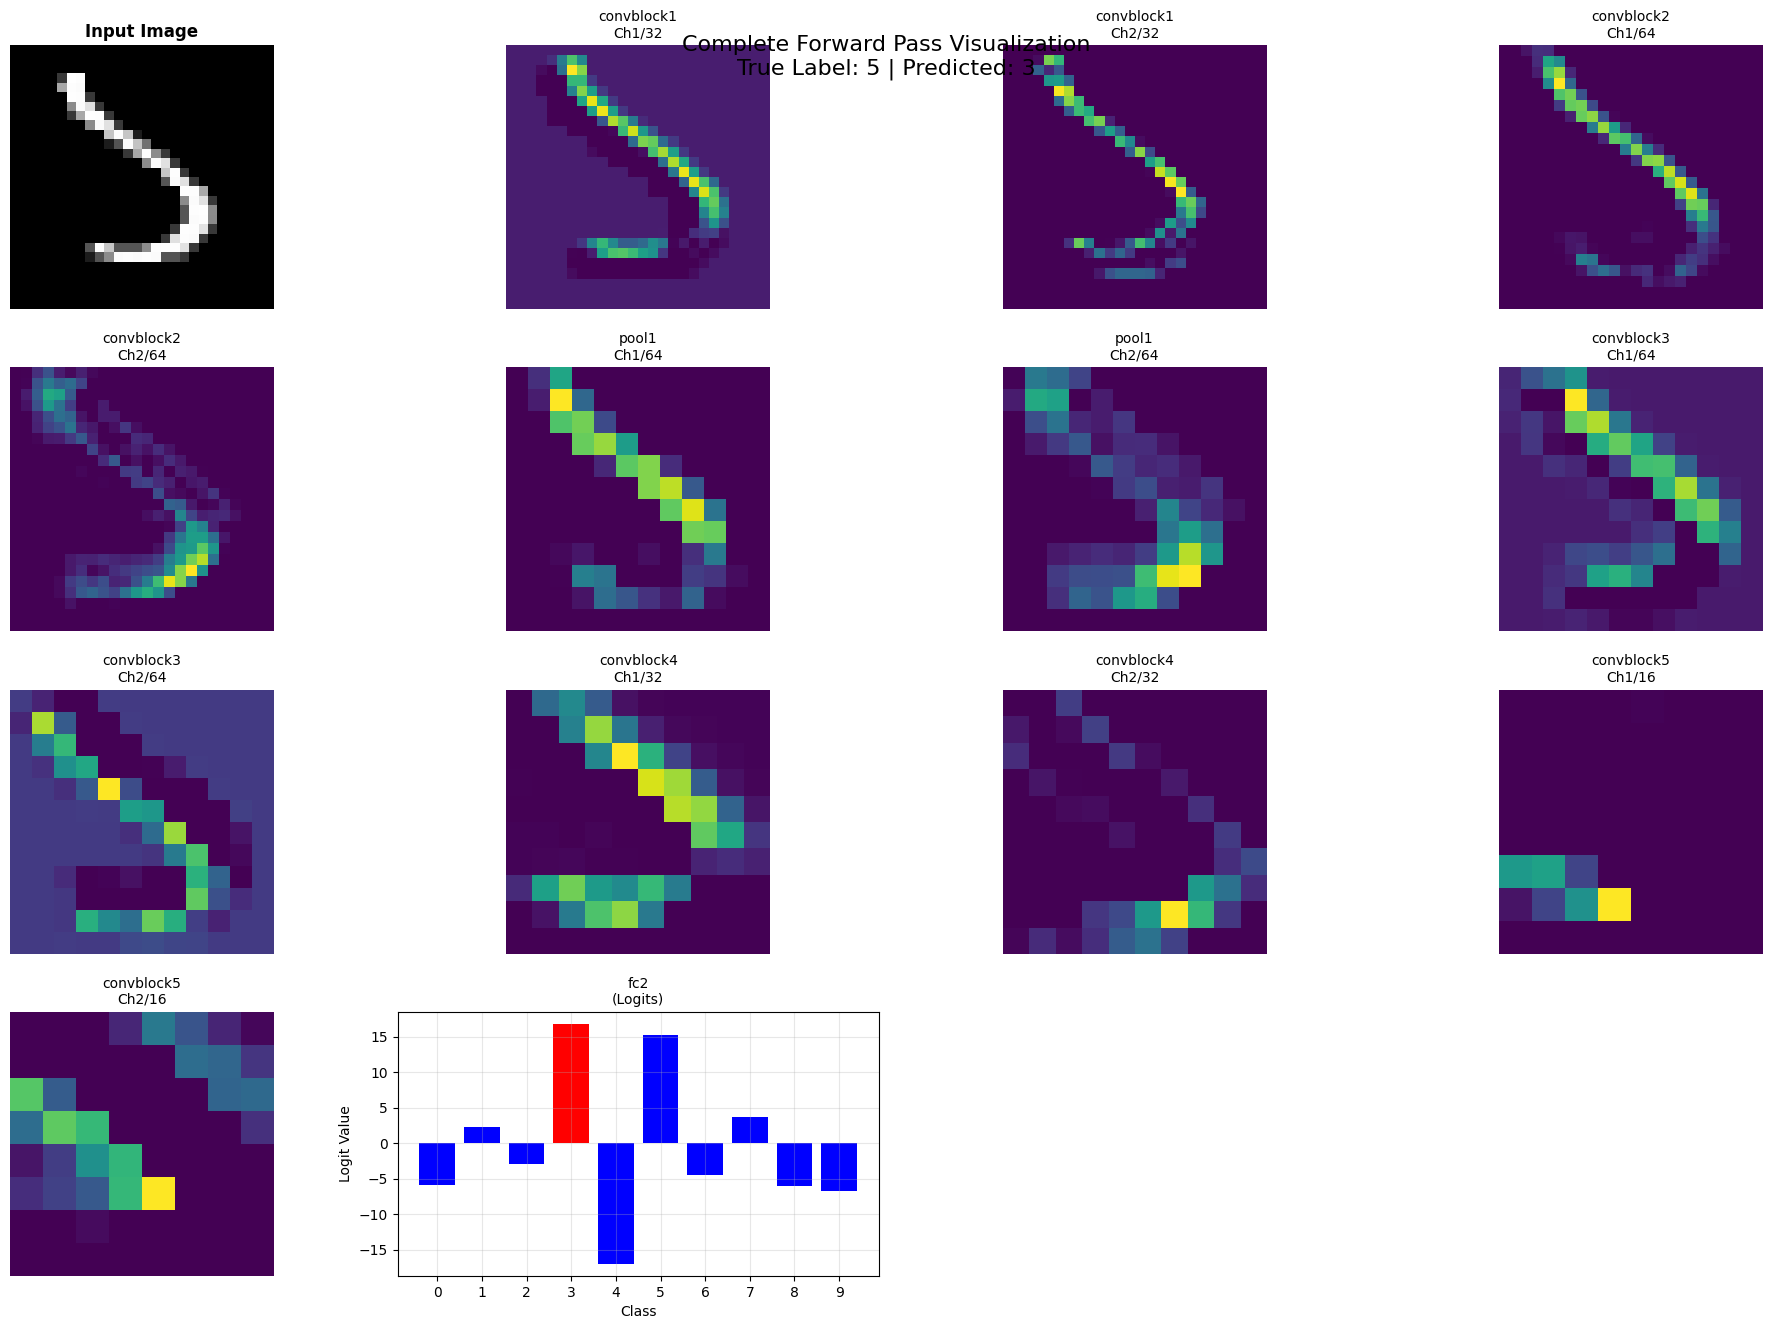


DETAILED LAYER OUTPUT STATISTICS

convblock1 (Conv Layer):
  Shape: torch.Size([1, 32, 26, 26])
  Mean activation: 0.2433
  Std activation: 0.3833
  Min: 0.0000, Max: 3.9691
  Sparsity (% zeros): 40.22%

convblock2 (Conv Layer):
  Shape: torch.Size([1, 64, 24, 24])
  Mean activation: 0.1909
  Std activation: 0.4326
  Min: 0.0000, Max: 5.2511
  Sparsity (% zeros): 62.33%

pool1 (Conv Layer):
  Shape: torch.Size([1, 64, 12, 12])
  Mean activation: 0.3240
  Std activation: 0.5995
  Min: 0.0000, Max: 5.2511
  Sparsity (% zeros): 50.43%

convblock3 (Conv Layer):
  Shape: torch.Size([1, 64, 12, 12])
  Mean activation: 0.1720
  Std activation: 0.4325
  Min: 0.0000, Max: 5.1349
  Sparsity (% zeros): 59.58%

convblock4 (Conv Layer):
  Shape: torch.Size([1, 32, 10, 10])
  Mean activation: 0.4502
  Std activation: 1.0257
  Min: 0.0000, Max: 8.6169
  Sparsity (% zeros): 61.12%

convblock5 (Conv Layer):
  Shape: torch.Size([1, 16, 8, 8])
  Mean activation: 0.4669
  Std activation: 1.3357
  Min: 0.

In [26]:
# Visualize the complete forward pass through all layers
def visualize_complete_forward_pass(model, device, test_loader):
    """
    Choose a random misclassified image from test set and visualize outputs through all layers
    """
    model.eval()
    
    # Find a random misclassified sample
    sample_image = None
    true_label = None
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Find misclassified samples
            incorrect_mask = pred.squeeze() != target
            
            if incorrect_mask.any():
                # Get indices of misclassified samples
                incorrect_indices = incorrect_mask.nonzero(as_tuple=True)[0]
                
                # Choose a random one
                import random
                random_idx = random.choice(incorrect_indices.cpu().numpy())
                
                sample_image = data[random_idx:random_idx+1]
                true_label = target[random_idx].cpu().item()
                break
    
    if sample_image is None:
        print("No misclassified samples found in the test data!")
        return
    
    print(f"Selected random misclassified image with true label: {true_label}")
    print(f"Image shape: {sample_image.shape}")
    
    # Store outputs at each layer
    layer_outputs = {}
    layer_names = []
    
    # Manual forward pass to capture intermediate outputs
    with torch.no_grad():
        # Layer 1: convblock1
        x = model.convblock1(sample_image)
        layer_outputs['convblock1'] = x.cpu()
        layer_names.append('convblock1')
        print(f"convblock1 output shape: {x.shape}")
        
        # Layer 2: convblock2
        x = model.convblock2(x)
        layer_outputs['convblock2'] = x.cpu()
        layer_names.append('convblock2')
        print(f"convblock2 output shape: {x.shape}")
        
        # Layer 3: pool1
        x = model.pool1(x)
        layer_outputs['pool1'] = x.cpu()
        layer_names.append('pool1')
        print(f"pool1 output shape: {x.shape}")
        
        # Layer 4: convblock3
        x = model.convblock3(x)
        layer_outputs['convblock3'] = x.cpu()
        layer_names.append('convblock3')
        print(f"convblock3 output shape: {x.shape}")
        
        # Layer 5: convblock4
        x = model.convblock4(x)
        layer_outputs['convblock4'] = x.cpu()
        layer_names.append('convblock4')
        print(f"convblock4 output shape: {x.shape}")
        
        # Layer 6: convblock5
        x = model.convblock5(x)
        layer_outputs['convblock5'] = x.cpu()
        layer_names.append('convblock5')
        print(f"convblock5 output shape: {x.shape}")
        
        # Layer 7: Flatten and fc1
        x_flat = x.view(-1, 8*8*16)
        x = model.fc1(x_flat)
        layer_outputs['fc1'] = x.cpu()
        layer_names.append('fc1')
        print(f"fc1 output shape: {x.shape}")

        x = model.fc2(x)
        layer_outputs['fc2'] = x.cpu()   
        layer_names.append('fc2')
        print(f"fc2 output shape: {x.shape}")     
        # Get prediction
        pred_label = x.argmax(dim=1).item()
        print(f"Predicted label: {pred_label}")
    
    # Create visualization
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle(f'Complete Forward Pass Visualization\nTrue Label: {true_label} | Predicted: {pred_label}', 
                 fontsize=16, y=0.95)
    
    # Original image
    plt.subplot(6, 4, 1)
    plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
    plt.title('Input Image', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    subplot_idx = 2
    
    for layer_name in layer_names:
        output = layer_outputs[layer_name]
        output_np = output.squeeze().numpy()
        
        if layer_name == 'fc2':
            # For FC layer, show the 10 class logits as a bar chart
            plt.subplot(6, 4, subplot_idx)
            plt.bar(range(10), output_np, color=['red' if i == pred_label else 'blue' for i in range(10)])
            plt.title(f'{layer_name}\n(Logits)', fontsize=10)
            plt.xlabel('Class')
            plt.ylabel('Logit Value')
            plt.xticks(range(10))
            plt.grid(True, alpha=0.3)
            
        elif len(output.shape) == 4:  # Convolutional layers (batch, channels, height, width)
            batch_size, num_channels, height, width = output.shape
            
            # Show first few channels (up to 2) as individual feature maps
            channels_to_show = min(2, num_channels)
            
            for ch in range(channels_to_show):
                plt.subplot(6, 4, subplot_idx)
                plt.imshow(output_np[ch], cmap='viridis')
                plt.title(f'{layer_name}\nCh{ch+1}/{num_channels}', fontsize=10)
                plt.axis('off')
                subplot_idx += 1
                
                if subplot_idx > 24:  # Don't exceed subplot grid
                    break
            
            # If we have more channels, skip to next layer position
            if channels_to_show < num_channels and subplot_idx <= 24:
                subplot_idx += (2 - channels_to_show)
        
        if subplot_idx > 24:
            break
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics for each layer
    print("\n" + "="*60)
    print("DETAILED LAYER OUTPUT STATISTICS")
    print("="*60)
    
    for layer_name in layer_names:
        output = layer_outputs[layer_name]
        output_np = output.numpy()
        
        if layer_name in ['fc1', 'fc2']:
            print(f"\n{layer_name} (FC Layer):")
            print(f"  Shape: {output.shape}")
            print(f"  Mean: {output_np.mean():.4f}")
            print(f"  Std: {output_np.std():.4f}")
            print(f"  Min: {output_np.min():.4f}, Max: {output_np.max():.4f}")
            if layer_name == 'fc2':
                print(f"  Predicted class: {pred_label} (logit: {output_np[0, pred_label]:.4f})")
        else:
            print(f"\n{layer_name} (Conv Layer):")
            print(f"  Shape: {output.shape}")
            print(f"  Mean activation: {output_np.mean():.4f}")
            print(f"  Std activation: {output_np.std():.4f}")
            print(f"  Min: {output_np.min():.4f}, Max: {output_np.max():.4f}")
            print(f"  Sparsity (% zeros): {(output_np == 0).mean() * 100:.2f}%")

# Call the function to visualize complete forward pass
visualize_complete_forward_pass(model, device, test_loader)